In [1]:
# !set CUDA_VISIBLE_DEVICES=""
# !set CUDA_LAUNCH_BLOCKING=1

In [1]:
import pandas as pd
import sklearn
import os
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
os.environ["KERAS_BACKEND"] = 'torch'
# os.environ["CUDA_VISIBLE_DEVICES"] = "" 
import keras

In [2]:
# torch.backends.cudnn.enabled = False
# torch.cuda.is_available = lambda: False
# torch.device("cpu")

device(type='cpu')

In [2]:
torch.cuda.is_available()

True

In [3]:
df = pd.read_csv('pmi-data.csv')
df = df.loc[df['split'] == 'train']

In [4]:
%%html
<h1>1. Datasets and Dataloaders</h1>

In [5]:
train_data, valid_data = sklearn.model_selection.train_test_split(df, test_size=0.25, shuffle=True, random_state=120)

In [6]:
class StrokeDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.labels = data['stroke']
        self.samples = data.drop(columns=['stroke', 'id', 'split'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):        
        return torch.Tensor(self.samples.iloc[0].values), torch.tensor(self.labels.iloc[idx])

In [7]:
train_dataloader = DataLoader(StrokeDataset(train_data), batch_size=16, shuffle=True)
valid_dataloader = DataLoader(StrokeDataset(valid_data))

In [8]:
%%html
<h3>I think shuffling is a good idea because if we take a look at the pmi-data.csv we can see that all the cases with stroke=1 come first in the csv so that means if we didnt shuffle, all of them would be chosen for the training and none would be left for the testing</h3>

In [9]:
%%html
<h1>2. Model</h1>

In [100]:
import torch.nn.functional as F
class Model(torch.nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.l1 = torch.nn.Linear(in_size, 16)
        self.l2 = torch.nn.Linear(16, 8)
        self.l3 = torch.nn.Linear(8, 8)
        self.l4 = torch.nn.Linear(8, 8)
        self.l5 = torch.nn.Linear(8, 8)
        self.l6 = torch.nn.Linear(8, 8)
        self.l7 = torch.nn.Linear(8, 8)
        # self.l8 = torch.nn.Linear(16, 16)
        # self.l9 = torch.nn.Linear(16, 16)
        # self.l10 = torch.nn.Linear(16, 8)
        # self.l11 = torch.nn.Linear(32, 16)
        self.l12 = torch.nn.Linear(8, out_size)

        torch.nn.init.xavier_uniform_(self.l1.weight)
        torch.nn.init.xavier_uniform_(self.l2.weight)
        torch.nn.init.xavier_uniform_(self.l3.weight)
        torch.nn.init.xavier_uniform_(self.l4.weight)
        torch.nn.init.xavier_uniform_(self.l5.weight)
        torch.nn.init.xavier_uniform_(self.l6.weight)
        torch.nn.init.xavier_uniform_(self.l7.weight)
        torch.nn.init.xavier_uniform_(self.l12.weight)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = F.relu(self.l7(x))
        # x = F.relu(self.l8(x))
        # x = F.relu(self.l9(x))
        # x = F.relu(self.l10(x))
        # x = F.relu(self.l11(x))
        x = self.l12(x)
        return x.squeeze()

def get_y_pred_y_true_valid_loss(model, threshold = 0.5):
    y_pred = []
    y_true = []
    valid_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader, 0):
            features, labels = data
            y_true.append(labels[0])
            outputs = model.forward(features)

            loss = loss_fn(outputs, labels[0].float())
            valid_loss += loss.item()
            y_pred.append((torch.sigmoid(outputs) > threshold).int())
    return y_pred, y_true, valid_loss

In [78]:
model = Model(10, 1)

In [12]:
# for param in model.parameters():
#     print(param)

In [13]:
%%html
<h1>3. Optimizer and Loss function</h1>

In [79]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [15]:
%%html
<h1>4. Training </h1>

In [80]:
N_EPOCHS = 30

best_acc = 0

hist_train_loss = []
hist_valid_loss = []
hist_accuracy = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    valid_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    y_pred, y_true, valid_loss = get_y_pred_y_true_valid_loss(model)

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}')
    if accuracy > best_acc:
        torch.save(model.state_dict(), 'best_unbalanced_accuracy')
        best_acc = accuracy

    hist_train_loss.append(train_loss)
    hist_valid_loss.append(valid_loss)
    hist_accuracy.append(accuracy)

Epoch 0, accuracy: 0.9565217391304348, train_loss=0.2541069799839561, valid_loss=0.21584521169247833
Epoch 1, accuracy: 0.9565217391304348, train_loss=0.22538722606737221, valid_loss=0.2304527241250743
Epoch 2, accuracy: 0.9565217391304348, train_loss=0.22491346527613812, valid_loss=0.25978090452111285
Epoch 3, accuracy: 0.9565217391304348, train_loss=0.22154308032633654, valid_loss=0.2511922483858855
Epoch 4, accuracy: 0.9565217391304348, train_loss=0.22469423166406688, valid_loss=0.23111102892004926
Epoch 5, accuracy: 0.9565217391304348, train_loss=0.22423123568296432, valid_loss=0.24951036598371423
Epoch 6, accuracy: 0.9565217391304348, train_loss=0.22331332459823408, valid_loss=0.1984729766845703
Epoch 7, accuracy: 0.9565217391304348, train_loss=0.22422172685167682, valid_loss=0.20761188216831372
Epoch 8, accuracy: 0.9565217391304348, train_loss=0.22261043093097743, valid_loss=0.22514504971711533
Epoch 9, accuracy: 0.9565217391304348, train_loss=0.22629365202651094, valid_loss=0.22

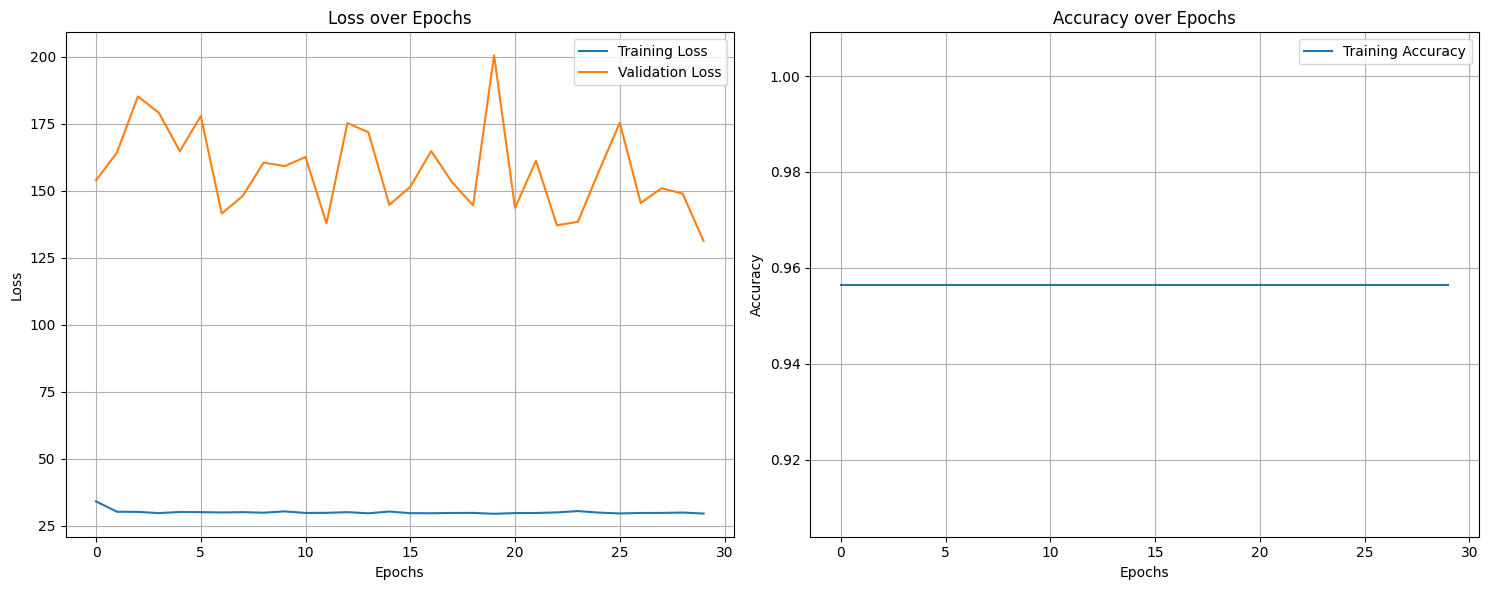

In [81]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(hist_train_loss, label='Training Loss')
plt.plot(hist_valid_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_accuracy, label='Training Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [278]:
%%html
<h1>5. Evaluation</h1>

In [82]:
model.load_state_dict(torch.load('best_unbalanced_accuracy'))
y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)

C:\Users\Fabi\AppData\Local\Temp\ipykernel_25140\3707983611.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_unbalanced_accuracy'))

Precision: 0.0
Recall: 0.0
F1_score: 0.0


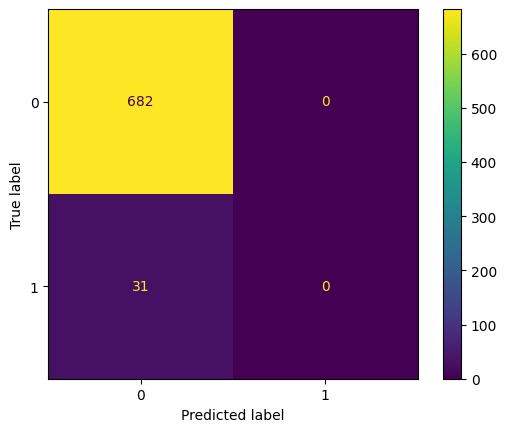

In [83]:
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred,zero_division=0)
f1_score = sklearn.metrics.f1_score(y_true, y_pred,zero_division=0)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [84]:
%%html
<h1>6. Balance the training data distribution</h1>

In [132]:
model = Model(10, 1)
pos_weight = torch.tensor(train_data['stroke'].loc[train_data.stroke == 0].count() / train_data['stroke'].loc[train_data.stroke == 1].count())
optimizer = torch.optim.Adam(model.parameters(), lr=0.000008)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [86]:
pos_weight

tensor(16.5328, dtype=torch.float64)

In [103]:
# Should reach <0.5 loss on 10 samples
x_tiny, y_tiny = next(iter(train_dataloader))[:10]
for _ in range(3000):
    optimizer.zero_grad()
    loss = loss_fn(model(x_tiny), y_tiny.float())
    loss.backward()
    optimizer.step()
print("Overfit test loss:", loss.item())

Overfit test loss: 0.0


In [137]:
N_EPOCHS = 30

best_f1_score = -1

hist_train_loss = []
hist_valid_loss = []

hist_accuracy = []
hist_precision = []
hist_recall = []
hist_f1_score = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    valid_loss = 0

    
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        total_grad = 0
        # for p in model.parameters():
        #     if p.grad is not None:
        #         total_grad += p.grad.norm().item()
        # if total_grad < 0.1:
        #     print('vanishing gradient')
        # if total_grad > 1000:
        #     print('exploding gradient')
    
        # for name, param in model.named_parameters():
        #     print(param.grad)
    
    y_pred, y_true, valid_loss = get_y_pred_y_true_valid_loss(model)

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, zero_division=0)
    recall = sklearn.metrics.recall_score(y_true, y_pred, zero_division=0)
    precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)

    hist_f1_score.append(f1_score)
    hist_recall.append(recall)
    hist_precision.append(precision)
    
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}, f1_score={f1_score}, recall={recall}, precision={precision}, {"*" if (f1_score > best_f1_score) else None}')
    if f1_score > best_f1_score:
        torch.save(model.state_dict(), 'best_balanced_f1')
        best_f1_score = f1_score

    hist_train_loss.append(train_loss)
    hist_valid_loss.append(valid_loss)
    hist_accuracy.append(accuracy)

Epoch 0, accuracy: 0.9565217391304348, train_loss=1.3604603807872802, valid_loss=1.1661871619846509, f1_score=0.0, recall=0.0, precision=0.0, *
Epoch 1, accuracy: 0.9565217391304348, train_loss=1.3629866111189572, valid_loss=1.1648508621298748, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 2, accuracy: 0.9565217391304348, train_loss=1.352917714350259, valid_loss=1.1634047186892966, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 3, accuracy: 0.9565217391304348, train_loss=1.3494814209528823, valid_loss=1.1621385398118391, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 4, accuracy: 0.9565217391304348, train_loss=1.3462997617116614, valid_loss=1.1609130320341692, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 5, accuracy: 0.9565217391304348, train_loss=1.3433234446973943, valid_loss=1.1599000433216924, f1_score=0.0, recall=0.0, precision=0.0, None
Epoch 6, accuracy: 0.9565217391304348, train_loss=1.3406353067995898, valid_loss=1.1587971915369448, f1_score=0.0, recall=

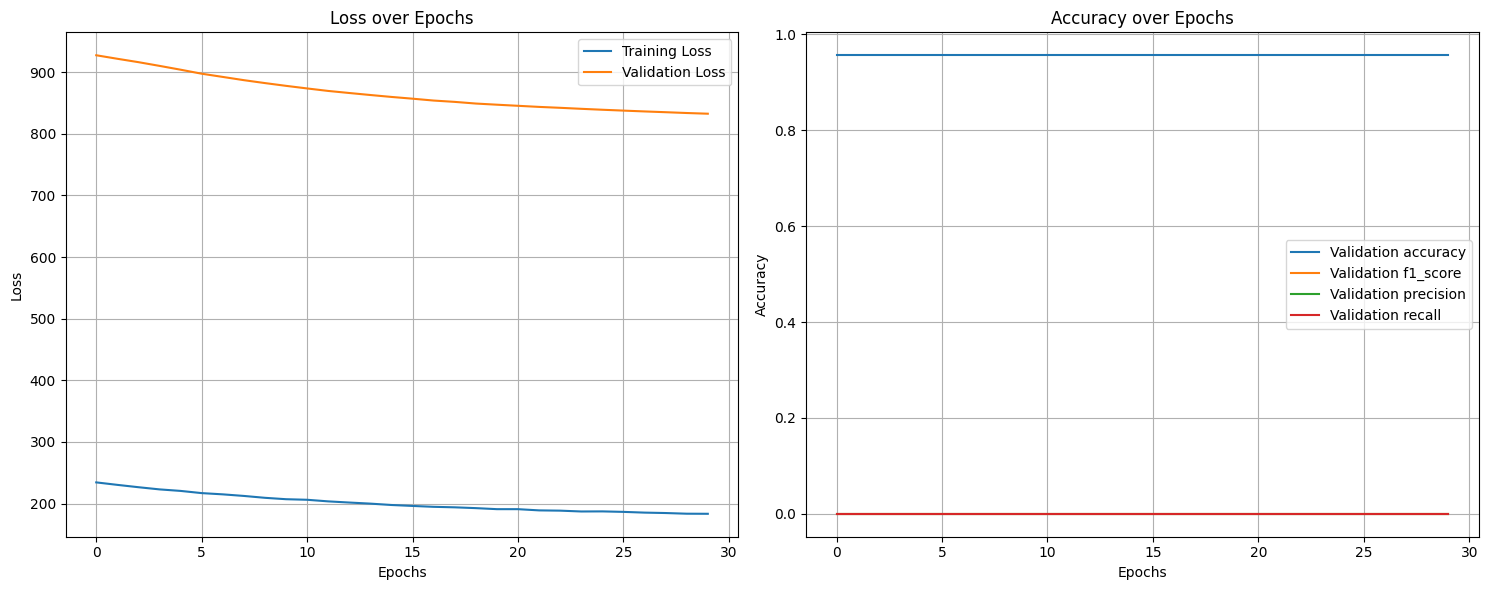

In [136]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(hist_train_loss, label='Training Loss')
plt.plot(hist_valid_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_accuracy, label='Validation accuracy')
plt.plot(hist_f1_score, label='Validation f1_score')
plt.plot(hist_precision, label='Validation precision')
plt.plot(hist_recall, label='Validation recall')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

C:\Users\Fabi\AppData\Local\Temp\ipykernel_25140\2614316706.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_balanced_f1'))


Precision: 0.043478260869565216
Recall: 1.0
F1_score: 0.08333333333333333


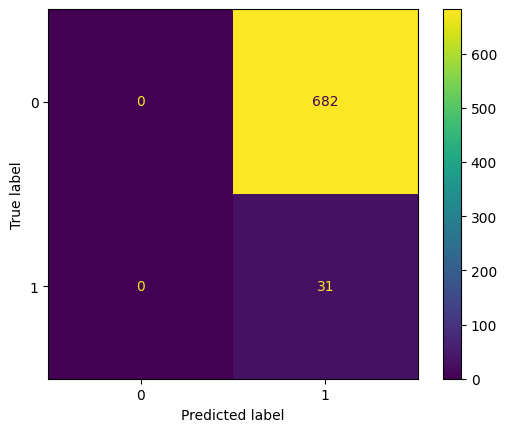

In [93]:
model.load_state_dict(torch.load('best_balanced_f1'))
y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)
        
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred)
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [288]:
%%html
<h1>7. Focal Loss</h1>

In [289]:
class BinaryFocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        pt = torch.exp(-BCE_loss)  # pt = p if target=1, else 1-p
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        F_loss = alpha_t * (1 - pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [290]:
model = Model(10, 1)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = BinaryFocalLoss(alpha=0.7, gamma=2)

In [ ]:
N_EPOCHS = 30

best_f1_score = 0

hist_train_loss = []
hist_valid_loss = []

hist_accuracy = []
hist_precision = []
hist_recall = []
hist_f1_score = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    valid_loss = 0
    
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data
        
        optimizer.zero_grad()

        outputs = model(features).squeeze()
        #y_true = torch.tensor(labels).to(torch.float)
        loss = loss_fn(outputs, labels.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, zero_division=0)
    recall = sklearn.metrics.recall_score(y_true, y_pred, zero_division=0)
    precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)

    hist_f1_score.append(f1_score)
    hist_recall.append(recall)
    hist_precision.append(precision)
    
    print(f'Epoch {epoch}, accuracy: {accuracy}, train_loss={train_loss / len(train_dataloader)}, valid_loss={valid_loss / len(valid_dataloader)}, f1_score={f1_score}, recall={recall}, precision={precision}, {"*" if (f1_score > best_f1_score) else None}')
    if f1_score > best_f1_score:
        torch.save(model.state_dict(), 'best_balanced_f1_focal_loss')
        best_f1_score = f1_score

    hist_train_loss.append(train_loss)
    hist_valid_loss.append(valid_loss)
    hist_accuracy.append(accuracy)

C:\Users\Fabi\AppData\Local\Temp\ipykernel_25140\1604072130.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_balanced_f1_focal_loss

Precision: 0.043478260869565216
Recall: 1.0
F1_score: 0.08333333333333333


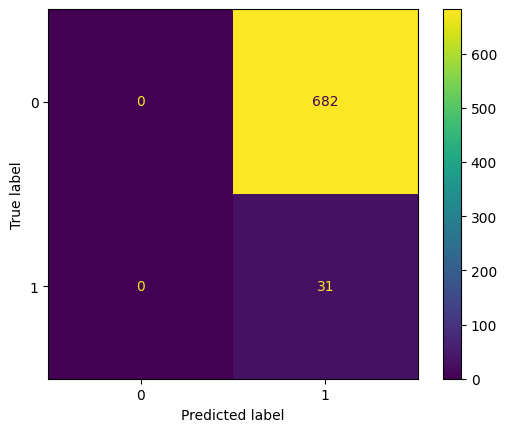

In [26]:
model =  Model(10, 1)
model.load_state_dict(torch.load('best_balanced_f1_focal_loss'))
y_pred, y_true, _ = get_y_pred_y_true_valid_loss(model)
        
conf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, zero_division=0)
recall = sklearn.metrics.recall_score(y_true, y_pred)
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1_score: {f1_score}')
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix).plot()

In [293]:
%%html
<h1>8. Inspecting model outputs. NOT DONE YET</h1>

In [27]:
model_unbalanced_accuracy = Model(10, 1)
model_unbalanced_accuracy.load_state_dict(torch.load('best_unbalanced_accuracy'))

model_balanced_f1 = Model(10, 1)
model_balanced_f1.load_state_dict(torch.load('best_balanced_f1'))

model_balanced_f1_focal = Model(10, 1)
model_balanced_f1_focal.load_state_dict(torch.load('best_balanced_f1_focal_loss'))

C:\Users\Fabi\AppData\Local\Temp\ipykernel_25140\1535333809.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_unbalanced_accuracy.load_state_dict(torch.load('best_un

<All keys matched successfully>

In [296]:
def probabilities(model):
    probs = []
    with torch.no_grad():
        for data, label in valid_dataloader:
            if label == 0:
                continue
            logits = model(data)
            probs.append(torch.sigmoid(logits))        
    return np.array(probs)

vals_model_unbalanced_accuracy = probabilities(model_unbalanced_accuracy)[0]
vals_model_balanced_f1 = probabilities(model_balanced_f1)[0]
vals_model_f1_focal = probabilities(model_balanced_f1_focal)[0]

TypeError: object of type 'numpy.float32' has no len()

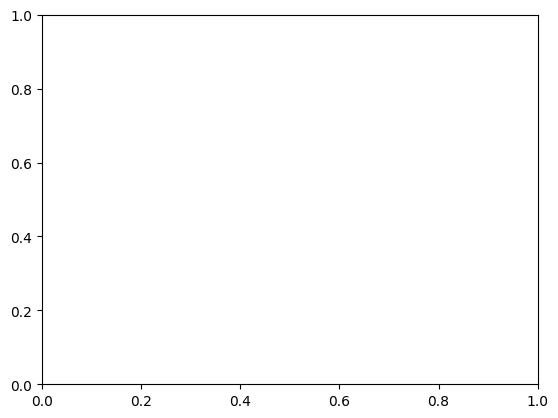

In [297]:
fig, ax = plt.subplots()

N = len(vals_model_unbalanced_accuracy)
x = np.arange(N)  # x-axis positions
width = 0.25  # Width of each bar

# Plot each set of bars with adjusted positions
ax.bar(x - width, vals_model_unbalanced_accuracy, width,
       edgecolor='white', linewidth=0.7, label='Unbalanced Accuracy')
ax.bar(x, vals_model_balanced_f1, width,
       edgecolor='white', linewidth=0.7, label='Balanced F1')
ax.bar(x + width, vals_model_f1_focal, width,
       edgecolor='white', linewidth=0.7, label='F1 Focal')

# Configure axes and labels
ax.set(
    xticks=x,  # All values in the list (indices)
    ylim=(0, 1),
    yticks=np.linspace(0, 1, 11)  # Ticks every 0.1
)
ax.legend()

plt.show()

In [298]:
%%html
<h1>9. Beyond default thresholds</h1>

In [31]:
def get_f1_score_models(threshold):
    f1_scores_model_unbalanced_accuracy = None
    f1_scores_model_balanced_f1 = None
    f1_scores_model_balanced_f1_focal = None

    y_pred_model_unbalanced_accuracy = []
    y_pred_model_balanced_f1 = []
    y_pred_model_balanced_f1_focal = []
    y_true = []
    
    y_pred_model_unbalanced_accuracy, y_true_1, _ = get_y_pred_y_true_valid_loss(model_unbalanced_accuracy, threshold)
    y_pred_model_balanced_f1, y_true_2, _ = get_y_pred_y_true_valid_loss(model_balanced_f1, threshold)
    y_pred_model_balanced_f1_focal, y_true_3, _ = get_y_pred_y_true_valid_loss(model_balanced_f1_focal, threshold)

    f1_scores_model_unbalanced_accuracy = sklearn.metrics.f1_score(y_true_1, y_pred_model_unbalanced_accuracy)
    f1_scores_model_balanced_f1 = sklearn.metrics.f1_score(y_true_2, y_pred_model_balanced_f1)
    f1_scores_model_balanced_f1_focal = sklearn.metrics.f1_score(y_true_3, y_pred_model_balanced_f1_focal)

    return f1_scores_model_unbalanced_accuracy, f1_scores_model_balanced_f1, f1_scores_model_balanced_f1_focal

In [52]:
history_thresholds = []
maximum = 0
for threshold in np.arange(0.25, 0.76, 0.01):
    history_thresholds.append(get_f1_score_models(threshold))
    maximum = max(maximum, max(history_thresholds[-1]))

In [61]:
%%html
<h1>10. Threshold sensitivity</h1>

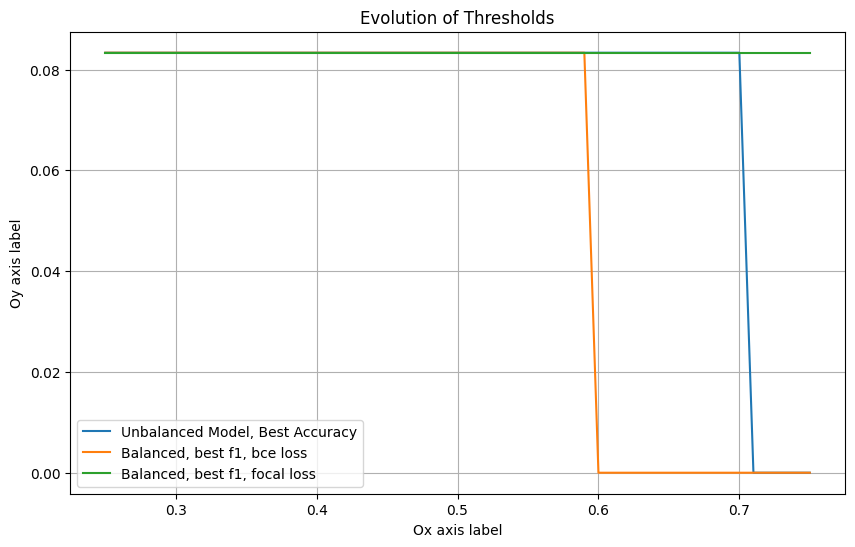

In [60]:
x = np.arange(0.25, 0.76, 0.01)

a = [t[0] for t in history_thresholds]
b = [t[1] for t in history_thresholds]
c = [t[2] for t in history_thresholds]

plt.figure(figsize=(10, 6))
plt.plot(x, a, label='Unbalanced Model, Best Accuracy')
plt.plot(x, b, label='Balanced, best f1, bce loss')
plt.plot(x, c, label='Balanced, best f1, focal loss')

plt.xlabel('Ox axis label')
plt.ylabel('Oy axis label')
plt.title('Evolution of Thresholds')
plt.legend()
plt.grid(True)
plt.show()